<a href="https://colab.research.google.com/github/dimsparagis0210/DFU-using-Deep-Learning/blob/main/Faster_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faster-RCNN Model Development

#### The goal of this BSc thesis is to develop a Deep Learning model for Object Detection. Specifically, the object of the model will be to detect ulcers in Diabetic Foots (DFU)

## Getting Dataset from Google drive

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# Define dataset path (adjust if needed)
dataset = '/content/drive/MyDrive/DFU_Data_Coco'
trainset = dataset + '/images/train'
testset = dataset + '/images/test'
validset = dataset + '/images/valid'

# List categories (folders)
os.listdir('/content/drive/MyDrive')

['Colab Notebooks',
 'ML',
 'Machine Learning A-Z (Model Selection)',
 'Deep Learning',
 'ML_task',
 'Screencastify',
 'DFU',
 'IoT, Big Data, AI Smart Farms.gdoc',
 'Conceptual Analysis of the Study on Environmentally Sustainable Smart Cities.gdoc',
 'DFU_Data_Tensorflow',
 'Ενοποιημένες',
 'DFU_Data_Yolo',
 'DFU_Data_Coco',
 'ssd_ulcer_best.pth',
 'faster_rcnn_ulcer_best.pth',
 'Faster-RCNN.ipynb',
 'SSD.ipynb']

In [3]:
import os
import torch
import torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset
from torchvision.datasets import CocoDetection
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Data Pipeline

In [4]:
import json

# Load the annotation file
with open('/content/drive/MyDrive/DFU_Data_Coco/annotations/train.coco.json') as f:
    data = json.load(f)

# Extract category IDs and names
categories = data.get('categories', [])
num_classes = len(categories)
class_names = [category['name'] for category in categories]

print(f"Number of classes: {num_classes}")
print("Class names:", class_names)
len(class_names)

Number of classes: 2
Class names: ['objects', 'Ulcer']


2

In [5]:
class UlcerDataset(Dataset):
    def __init__(self, img_dir, ann_file, transforms=None):
        self.dataset = CocoDetection(img_dir, ann_file)
        self.transforms = transforms

    def __getitem__(self, idx):
      img, target = self.dataset[idx]
      img_id = self.dataset.ids[idx]

      # Convert image to NumPy
      img = np.array(img).astype(np.uint8)

      boxes = []
      labels = []

      # Check if target has annotations
      if len(target) == 0:
          # Add a dummy box to prevent errors
          boxes = torch.tensor([[0, 0, 1, 1]], dtype=torch.float32)
          labels = torch.tensor([0], dtype=torch.int64)  # Background class
      else:
          for obj in target:
              if "bbox" not in obj:
                  continue

              bbox = obj["bbox"]  # COCO format: [x, y, width, height]
              x, y, w, h = bbox
              boxes.append([x, y, x + w, y + h])  # Convert to Pascal VOC format
              labels.append(obj["category_id"])

          boxes = torch.tensor(boxes, dtype=torch.float32)
          labels = torch.tensor(labels, dtype=torch.int64)

      # Apply augmentations
      if self.transforms:
          transformed = self.transforms(image=img, bboxes=boxes.tolist(), labels=labels.tolist())
          img = transformed["image"]
          boxes = torch.tensor(transformed["bboxes"], dtype=torch.float32)

      target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([img_id])}

      return img, target


    def __len__(self):
        return len(self.dataset)


In [ ]:
dataset = UlcerDataset(trainset, os.path.join('/content/drive/MyDrive/DFU_Data_Coco', 'annotations', 'train.coco.json'), transforms=None)
dataset.__len__()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


284

## Data Preprocessing

### Data Augmentation & Normalization

In [18]:
def get_transforms(train):
  if train:
    return A.Compose([
        A.Resize(512, 512),
        A.HorizontalFlip(p = 0.5),
        A.RandomBrightnessContrast(p = 0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
  else:
    return A.Compose([
        A.Resize(512, 512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_train_transforms():
    return A.Compose([
        A.Resize(320, 320),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_valid_transforms():
    return A.Compose([
        A.Resize(300, 300),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_test_transforms():
    return A.Compose([
        A.Resize(300, 300),
        A.Normalize(mean=(0.485, 0.456, 0.406),
                    std=(0.229, 0.224, 0.225)),
        ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


### Load the dataset and initilize UlcerDataset Objects

In [19]:
from torch.utils.data import DataLoader

# Paths to dataset
data_root = "/content/drive/MyDrive/DFU_Data_Coco"
train_img_dir = os.path.join(data_root, "images/train")
valid_img_dir = os.path.join(data_root, "images/valid")
test_img_dir = os.path.join(data_root, "images/test")

train_ann_file = os.path.join(data_root, "annotations/train.coco.json")
valid_ann_file = os.path.join(data_root, "annotations/valid.coco.json")
test_ann_file = os.path.join(data_root, "annotations/test.coco.json")

# Create dataset instances
train_dataset = UlcerDataset(train_img_dir, train_ann_file, transforms=get_transforms(train=True))
train_dataset_ssd = UlcerDataset(train_img_dir, train_ann_file, transforms=get_train_transforms())
valid_dataset = UlcerDataset(valid_img_dir, valid_ann_file, transforms=get_transforms(train=False))
test_dataset = UlcerDataset(test_img_dir, test_ann_file, transforms=get_transforms(train=False))

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
train_loader_ssd = DataLoader(train_dataset_ssd, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Test loading a batch
images, targets = next(iter(train_loader))
print("Batch loaded successfully")
print(f"Image shape: {images[0].shape}")
print(f"Target example: {targets[0]}")


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Batch loaded successfully
Image shape: torch.Size([3, 512, 512])
Target example: {'boxes': tensor([[ 38.4000,  51.2000,  76.0000, 122.0000]]), 'labels': tensor([1]), 'image_id': tensor([245])}


### Visualizations

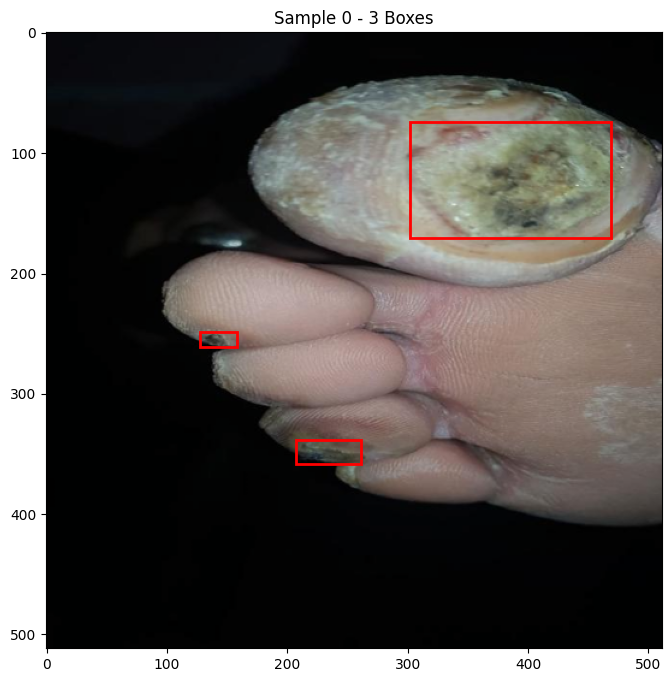

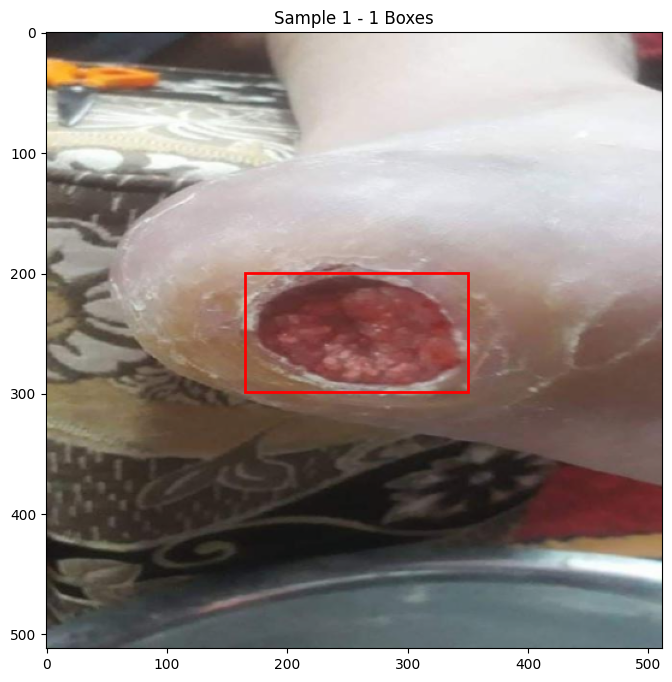

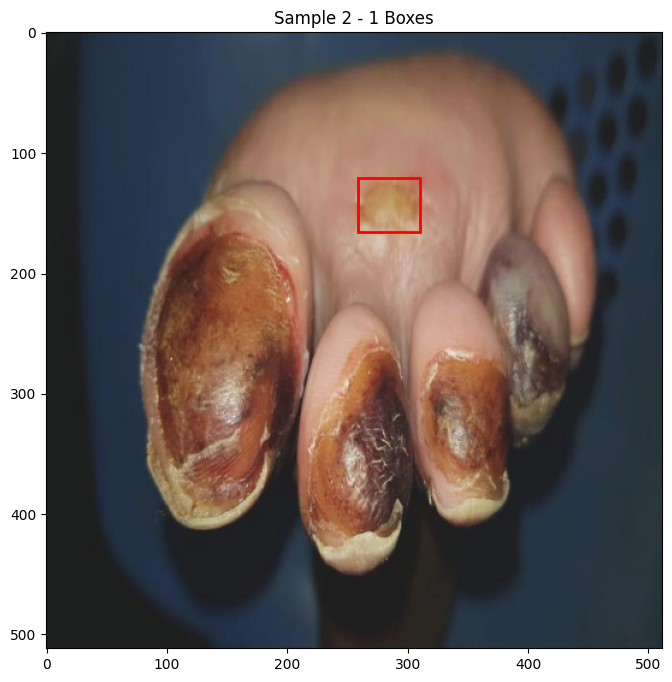

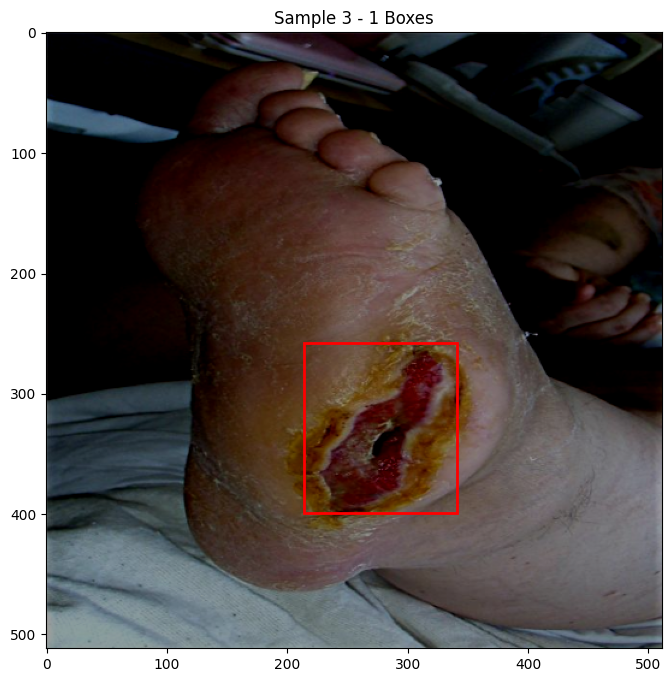

In [20]:
# Define function to visualize dataset samples
def visualize_sample(dataset, idx):
    img, target = dataset[idx]

    # Convert tensor image to NumPy array (if needed)
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

    # Denormalize (if necessary)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img * std + mean).clip(0, 1)  # Reverse normalization

    # Create plot
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)

    # Draw bounding boxes
    for box in target["boxes"]:
        x1, y1, x2, y2 = box.tolist()  # Convert tensor to list
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    ax.set_title(f"Sample {idx} - {len(target['boxes'])} Boxes")
    plt.show()

# Test visualization on the training dataset
visualize_sample(train_dataset, idx=0)  # Change idx to see different images
visualize_sample(train_dataset, idx=1)
visualize_sample(train_dataset, idx=2)
visualize_sample(train_dataset, idx=3)


## Model Development

### Hyperparameter Optimization

In [10]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 19.9 MB/s eta 0:00:00


In [21]:
import torch
import optuna
from torch.utils.data import DataLoader
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.optim import AdamW, SGD
import numpy as np
from torch.optim.lr_scheduler import StepLR


# Define function to load Faster R-CNN model
def get_faster_rcnn(num_classes, backbone="mobilnenet"):
    # weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
    # backbone = torchvision.models.mobilenet_v2(weights="IMAGENET1K_V2").features
    # backbone.out_channels = 1280
    # model = FasterRCNN(backbone, num_classes=num_classes)
    # model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="IMAGENET1K_V2")

    # Modify the classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Define training function
def train_model(model, train_loader, optimizer, device, epochs=3):
    model.train()
    scheduler = StepLR(optimizer, step_size=3, gamma=0.1)

    for epoch in range(epochs):
        for images, targets in train_loader:
            # Filter out images without any bounding boxes
            filtered_images = []
            filtered_targets = []

            for img, tgt in zip(images, targets):
                if tgt["boxes"].numel() > 0:  # Ensure at least one bbox exists
                    filtered_images.append(img)
                    filtered_targets.append(tgt)

            if len(filtered_images) == 0:
                continue  # Skip batch if all images have no bounding boxes

            # Move tensors to device
            filtered_images = [img.to(device) for img in filtered_images]
            filtered_targets = [{k: v.to(device) for k, v in t.items()} for t in filtered_targets]

            # Compute loss
            loss_dict = model(filtered_images, filtered_targets)
            loss = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        scheduler.step()

    return model


# Define evaluation function (Compute mAP)
def evaluate_model(model, valid_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for images, targets in valid_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i in range(len(images)):
                all_predictions.append(outputs[i]["boxes"].cpu().numpy())
                all_targets.append(targets[i]["boxes"].cpu().numpy())

    # Compute mean IoU (proxy for mAP)
    iou_scores = []
    for pred_boxes, gt_boxes in zip(all_predictions, all_targets):
        if len(pred_boxes) == 0 or len(gt_boxes) == 0:
            continue
        iou_scores.append(np.mean([np.max([iou(pred, gt) for gt in gt_boxes]) for pred in pred_boxes]))

    return np.mean(iou_scores) if iou_scores else 0.0

# IoU Calculation
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    return interArea / float(boxAArea + boxBArea - interArea)

def collate_fn(batch):
    return tuple(zip(*batch))

# Define objective function for Optuna
def objective(trial):
    # 🔍 Narrowed search space based on best trials
    lr = trial.suggest_float("lr", 5e-5, 2e-4, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-7, 1e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [2])  # Fixing to best value
    epochs = trial.suggest_int("epochs", 3, 10)

    # Load dataset
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    # Load model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = get_faster_rcnn(num_classes=2).to(device)

    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train with StepLR scheduler
    model = train_model(model, train_loader, optimizer, device, epochs=epochs)

    # Evaluate model
    mAP_score = evaluate_model(model, valid_loader, device)

    return mAP_score

# Run Optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15)

# # Print best hyperparameters
print("Best Hyperparameters:", study.best_params)

[I 2025-04-01 14:59:19,242] A new study created in memory with name: no-name-b019f3ec-369c-45f4-9b3c-91a7d6d8474d
[I 2025-04-01 15:00:14,226] Trial 0 finished with value: 0.0514206220931828 and parameters: {'lr': 8.116468995294398e-05, 'weight_decay': 8.274842936678693e-07, 'batch_size': 2, 'epochs': 6}. Best is trial 0 with value: 0.0514206220931828.
[I 2025-04-01 15:00:59,703] Trial 1 finished with value: 0.04884787953240236 and parameters: {'lr': 0.00012411267799537974, 'weight_decay': 1.2020191063943726e-06, 'batch_size': 2, 'epochs': 5}. Best is trial 0 with value: 0.0514206220931828.
[I 2025-04-01 15:01:36,746] Trial 2 finished with value: 0.05264729658064911 and parameters: {'lr': 8.70393787025489e-05, 'weight_decay': 2.0868818892984396e-07, 'batch_size': 2, 'epochs': 4}. Best is trial 2 with value: 0.05264729658064911.
[W 2025-04-01 15:01:45,485] Trial 3 failed with parameters: {'lr': 5.3880308104222066e-05, 'weight_decay': 1.572917668417876e-07, 'batch_size': 2, 'epochs': 8} b

KeyboardInterrupt: 

##### Optimization Results

In [ ]:
# # Best Hyperparameters: {'lr': 0.00014817087272703724, 'weight_decay': 3.6362933953733854e-06, 'batch_size': 2, 'epochs': 9} 0.5
# 2025-03-24 12:49:12,661] A new study created in memory with name: no-name-2fffa400-c2b5-4b50-96fe-23fc0de35d2a
# [I 2025-03-24 13:02:08,961] Trial 0 finished with value: 0.5037013850511008 and parameters: {'lr': 0.00014817087272703724, 'weight_decay': 3.6362933953733854e-06, 'batch_size': 2, 'epochs': 9}. Best is trial 0 with value: 0.5037013850511008.
# [I 2025-03-24 13:15:05,776] Trial 1 finished with value: 0.4758329717917745 and parameters: {'lr': 0.00014520877639172594, 'weight_decay': 2.562149759132764e-06, 'batch_size': 2, 'epochs': 9}. Best is trial 0 with value: 0.5037013850511008.
# [I 2025-03-24 13:20:58,229] Trial 2 finished with value: 0.39153929126413084 and parameters: {'lr': 5.207271982416591e-05, 'weight_decay': 9.478731852911813e-06, 'batch_size': 2, 'epochs': 4}. Best is trial 0 with value: 0.5037013850511008.
# [I 2025-03-24 13:33:54,557] Trial 3 finished with value: 0.47994150889522263 and parameters: {'lr': 0.00015548519513510972, 'weight_decay': 2.8036771612159616e-06, 'batch_size': 2, 'epochs': 9}. Best is trial 0 with value: 0.5037013850511008.
# [I 2025-03-24 13:46:50,328] Trial 4 finished with value: 0.4874133087433554 and parameters: {'lr': 0.00018760471687466994, 'weight_decay': 9.577603494523582e-07, 'batch_size': 2, 'epochs': 9}. Best is trial 0 with value: 0.5037013850511008.
# [I 2025-03-24 13:52:42,877] Trial 5 finished with value: 0.4268336091134846 and parameters: {'lr': 6.258524970084222e-05, 'weight_decay': 1.4206238603868577e-06, 'batch_size': 2, 'epochs': 4}. Best is trial 0 with value: 0.5037013850511008.
# [I 2025-03-24 13:57:10,242] Trial 6 finished with value: 0.22193233777155144 and parameters: {'lr': 0.00012743332798541843, 'weight_decay': 8.191979549207603e-07, 'batch_size': 2, 'epochs': 3}. Best is trial 0 with value: 0.5037013850511008.
# [I 2025-03-24 14:11:33,058] Trial 7 finished with value: 0.49656162697317896 and parameters: {'lr': 9.016461099014887e-05, 'weight_decay': 1.1011674957460417e-07, 'batch_size': 2, 'epochs': 10}. Best is trial 0 with value: 0.5037013850511008.
# [I 2025-03-24 14:18:50,400] Trial 8 finished with value: 0.47755587991429604 and parameters: {'lr': 8.092087307238933e-05, 'weight_decay': 2.3816839411778543e-07, 'batch_size': 2, 'epochs': 5}. Best is trial 0 with value: 0.5037013850511008.
# [I 2025-03-24 14:30:22,858] Trial 9 finished with value: 0.4625856578856531 and parameters: {'lr': 0.0001034247237941584, 'weight_decay': 4.552771423561729e-07, 'batch_size': 2, 'epochs': 8}. Best is trial 0 with value: 0.5037013850511008.
# [I 2025-03-24 14:40:29,301] Trial 10 finished with value: 0.40738534933372383 and parameters: {'lr': 0.00019999976212836925, 'weight_decay': 8.082998082255625e-06, 'batch_size': 2, 'epochs': 7}. Best is trial 0 with value: 0.5037013850511008.
# [I 2025-03-24 14:54:51,459] Trial 11 finished with value: 0.47743779362838606 and parameters: {'lr': 9.620929113468782e-05, 'weight_decay': 1.1185214891661031e-07, 'batch_size': 2, 'epochs': 10}. Best is trial 0 with value: 0.5037013850511008.
# [I 2025-03-24 15:09:13,568] Trial 12 finished with value: 0.43961341123810393 and parameters: {'lr': 7.892448622141941e-05, 'weight_decay': 1.1677538682158662e-07, 'batch_size': 2, 'epochs': 10}. Best is trial 0 with value: 0.5037013850511008.
# [I 2025-03-24 15:19:20,463] Trial 13 finished with value: 0.4657243344610774 and parameters: {'lr': 0.00011399430797347361, 'weight_decay': 3.9134442660867725e-06, 'batch_size': 2, 'epochs': 7}. Best is trial 0 with value: 0.5037013850511008.
# [I 2025-03-24 15:30:52,010] Trial 14 finished with value: 0.44918674514306506 and parameters: {'lr': 8.329630254229763e-05, 'weight_decay': 3.4086635151744375e-07, 'batch_size': 2, 'epochs': 8}. Best is trial 0 with value: 0.5037013850511008.
# Best Hyperparameters: {'lr': 0.00014817087272703724, 'weight_decay': 3.6362933953733854e-06, 'batch_size': 2, 'epochs': 9}


### Training

In [ ]:
# Extract best hyperparameters
# best_params = study.best_params
# Best Hyperparameters: {'lr': 0.00014817087272703724, 'weight_decay': 3.6362933953733854e-06, 'batch_size': 2, 'epochs': 9}

# Load Faster R-CNN with 2 classes (ulcer vs. background)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_faster_rcnn(num_classes=2).to(device)

# Use AdamW optimizer with best LR & weight decay
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00014817087272703724, weight_decay=3.6362933953733854e-06)

# Train model for best epoch count
train_model(model, train_loader, optimizer, device, epochs=50)

# Save trained model
torch.save(model.state_dict(), "/content/drive/MyDrive/faster_rcnn_ulcer_best.pth")
print("✅ Final model training complete! Saved model.")

✅ Final model training complete! Saved model.


### Evaluation

In [ ]:
pip install pycocotools

##### Evaluating(Precision, Recall, F1, mAP)

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


IOU_THRESHOLD = 0.5  # You can adjust

def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = max(0, (boxA[2] - boxA[0])) * max(0, (boxA[3] - boxA[1]))
    boxBArea = max(0, (boxB[2] - boxB[0])) * max(0, (boxB[3] - boxB[1]))

    iou = interArea / float(boxAArea + boxBArea - interArea + 1e-6)
    return iou

def evaluate_detector(model, dataloader, device, iou_thresh=IOU_THRESHOLD):
    model.eval()
    all_preds, all_gts = [], []
    total_tp = 0
    total_fp = 0
    total_fn = 0
    iou_scores = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes = output["boxes"].cpu().numpy()
                scores = output["scores"].cpu().numpy()
                gt_boxes = target["boxes"].cpu().numpy()

                pred_boxes = pred_boxes[scores > 0.5]  # Confidence threshold

                matched_gt = set()
                matched_pred = set()

                for i, pb in enumerate(pred_boxes):
                    match_found = False
                    for j, gb in enumerate(gt_boxes):
                        iou = compute_iou(pb, gb)
                        if iou >= iou_thresh and j not in matched_gt:
                            matched_pred.add(i)
                            matched_gt.add(j)
                            total_tp += 1
                            iou_scores.append(iou)
                            match_found = True
                            break
                    if not match_found:
                        total_fp += 1

                total_fn += len(gt_boxes) - len(matched_gt)

    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-6)
    mAP = np.mean(iou_scores) if iou_scores else 0.0

    print(f"📊 Evaluation Results:")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"mAP@{iou_thresh}:   {mAP:.4f}")

def get_faster_rcnn(num_classes, backbone="mobilnenet"):
    # weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained=True)
    # backbone = torchvision.models.mobilenet_v2(weights="IMAGENET1K_V2").features
    # backbone.out_channels = 1280
    # model = FasterRCNN(backbone, num_classes=num_classes)
    # model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="IMAGENET1K_V2")

    # Modify the classifier head
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_faster_rcnn(num_classes=2).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/faster_rcnn_ulcer_best.pth', weights_only=True))
evaluate_detector(model, valid_loader, device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📊 Evaluation Results:
Precision: 0.6506
Recall:    0.7606
F1 Score:  0.7013
mAP@0.5:   0.7772


#### Visualizing Predictions

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def visualize_predictions(model, dataset, idx, device, score_threshold=0.5):
    model.eval()

    # Load image and target
    img, target = dataset[idx]
    img_tensor = img.to(device).unsqueeze(0)

    # Get model predictions
    with torch.no_grad():
        output = model(img_tensor)[0]

    # Denormalize image
    img = img.permute(1, 2, 0).cpu().numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img * std + mean).clip(0, 1)

    # Create plot
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(img)

    # 🔴 Predicted boxes (Red)
    for box, score in zip(output["boxes"], output["scores"]):
        if score > score_threshold:
            x1, y1, x2, y2 = box.cpu().numpy()
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                     linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)
            ax.text(x1, y1 - 5, f"Pred: {score:.2f}", color="red", fontsize=10)

    # ✅ Ground truth boxes (Green)
    for box in target["boxes"]:
        x1, y1, x2, y2 = box.numpy()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='lime', facecolor='none', linestyle='--')
        ax.add_patch(rect)
        ax.text(x1, y2 + 5, "GT", color="green", fontsize=10)

    ax.set_title(f"Ulcer Detection - Sample {idx}\nRed: Prediction | Green: Ground Truth")
    plt.axis("off")
    plt.show()


# Test visualization on the test dataset
for i in range(test_dataset.__len__()):
    visualize_predictions(model, test_dataset, idx=i, device=device)
